In [2]:
import pandas as pd
import numpy as np
import glob
import random
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.decomposition import NMF, PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error, f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier

from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Flatten, Embedding
from keras.optimizers import Adam
from keras.utils import plot_model
import multiprocessing
from matplotlib import pyplot
from gensim.models import Word2Vec
from csv import DictWriter
from collections import Counter
from dateutil import parser
%matplotlib inline
import warnings 
warnings.filterwarnings(action = 'ignore') 

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd /content/drive/My Drive/practicum_data/

Mounted at /content/drive/
/content/drive/My Drive/practicum_data


# Preprocessing: Merging, Tokenizing, and Vectorizing Labeled Datasets

In [4]:
def merge_csv() -> pd.DataFrame:
    """
    Obtain a list of all CSV files in a given directory, 
    iterate through each CSV file and load it into a DataFrame. 
    Concatenate all the DataFrames into a single one. Parse dates 
    and remove any duplicate rows based on the tweet_id column.
    """
    csv_files = glob.glob('*.csv')
    df_list = []
    for file in csv_files:
        if not file.startswith('stage_2'):
            df = pd.read_csv(file)
            df_list.append(df)

    df = pd.concat(df_list, axis=0, ignore_index=True)
    df['created_datetime'] = df['created_datetime'].apply(parser.parse)\
                                .apply(lambda x: x.strftime('%Y-%m-%d'))
    df['created_datetime'] = pd.to_datetime(df['created_datetime'])
    df.drop_duplicates(subset=['tweet_id'], inplace=True)
    return df

In [5]:
def text_clean_and_tokenize(text: str) -> object:
    '''
    Preprocess the text data by removing URLs, hashtags, 
    punctuations, and extra spaces. Convert uppercase 
    letters to lowercase, tokenize the words, remove 
    stopwords, and perform text lemmatization.
    '''
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'#\w+|\@\w+', '', text)
    text  = "".join((char if char.isalpha() else " ") for char in text)
    text = re.sub('[\W_]+', ' ', text)
    text = re.sub(' +', ' ',text)
    text = text.strip()
    text = text.lower()
    text = nltk.word_tokenize(text)#re.split('\W+', text)
    text = [word for word in text if word not in stop_words]

    ps = nltk.WordNetLemmatizer()
    text = [ps.lemmatize(w) for w in text]
    merged_text = ' '.join(text)
    return text, merged_text

In [6]:
df = merge_csv().reset_index(drop=True)
print(df.groupby('label')['label'].count())

label
0    1293
1     520
2     280
Name: label, dtype: int64


In [7]:
df['tokenized_tweets'] = df['content'].apply(lambda x: text_clean_and_tokenize(x))
df[['tokenized', 'merged']] = df['tokenized_tweets'].apply(lambda x: pd.Series(x))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2093 entries, 0 to 2092
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   tweet_id          2093 non-null   float64       
 1   created_datetime  2093 non-null   datetime64[ns]
 2   content           2093 non-null   object        
 3   author_id         2093 non-null   float64       
 4   place_id          2061 non-null   object        
 5   location          2061 non-null   object        
 6   longitude         2093 non-null   float64       
 7   latitude          2093 non-null   float64       
 8   county            2093 non-null   object        
 9   label             2093 non-null   int64         
 10  tokenized_tweets  2093 non-null   object        
 11  tokenized         2093 non-null   object        
 12  merged            2093 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(7)
memory usage: 212.7+ KB


# Warm-up: Splitting Training/Test Sets and Defining Performance Function

We split the labeled dataset into training and test sets with a ratio of 0.9 and 0.1, respectively. This ratio is chosen to provide sufficient training data for the text classification models to capture the data structures.

For text representation, we decided to use TF-IDF instead of GloVe embeddings like [the previous step](https://github.com/persecond17/Black_Bear_CDFW2023/blob/main/social_media_NLP_project/step_3_data_transformation/2_labeling.ipynb). While GloVe embeddings are pre-trained on large corpora and can effectively capture semantic relationships between words, TF-IDF is more suitable for handling a greater number of unique words and identifying important words in a given document, especially when there are more labeled records available.

In [8]:
X, y = df['merged'], df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)

tfidf = TfidfVectorizer(stop_words=list(stop_words))
tfidf.fit(X)
X_vectors = tfidf.transform(X)
X_train_vectors = tfidf.transform(X_train)
X_test_vectors = tfidf.transform(X_test)

X_vectors.shape, X_train_vectors.shape, X_test_vectors.shape

((2093, 3524), (1883, 3524), (210, 3524))

In [9]:
def print_performance(y_test, y_pred):
    """
    Compute the F1 score, accuracy, MSE (mean squared error) 
    and confusion matrix for the true values and predicted 
    values of a test dataset.
    """
    f1 = f1_score(y_test, y_pred, average='weighted')
    ac = accuracy_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print("F1 score: ", f1)
    print("Accuracy: ", ac)
    print("MSE: ", mse)
    print("Confusion matrix: ")
    print(cm)
    # return f1, ac, cm

In the upcoming chapter, I will explore six text classification models for our classification task. Each chapter will begin by introducing the baseline model, followed by tuning it through grid search, applying dimensionality reduction techniques, and implementing feature selection methods. The final model will be selected for ensemble modeling purposes.

Notes:
* I chose **grid search** since it's appropriate for small hyperparameter spaces and limited resources. 
* To reduce dimensionality, I applied **Principal Component Analysis (PCA)** and **Non-Negative Matrix Factorization (NMF)**. PCA transforms high-dimensional data into a smaller set of orthogonal components that capture the most significant information in the original data. NMF factors a non-negative matrix into the product of two non-negative matrices with lower rank.
* For feature selection, I used **Recursive Feature Elimination (RFE)**. RFE recursively removes features from the dataset and builds a model using the remaining features. It then ranks the features by their importance and removes the least important feature. This process repeats until the desired number of features is reached.

# Model 1: Naive Bayes (`MultinomialNB`)
* Assumes that the features are discrete and follow a multinomial distribution
* Commonly used for text classification problems where the features are word frequencies or counts
* Specifically designed to work with sparse input

### Baseline of NB

In [ ]:
nb = MultinomialNB()
nb.fit(X_train_vectors, y_train)
y_pred = nb.predict(X_test_vectors)

print_performance(y_test, y_pred)

F1 score:  0.7056840230784459
Accuracy:  0.7523809523809524
MSE:  0.46190476190476193
Confusion matrix: 
[[132   1   0]
 [ 34  24   0]
 [ 15   2   2]]


### Tune NB: Grid search best parameters

In [ ]:
nb = MultinomialNB()
param_grid = {
    'alpha': [x * 0.1 for x in range(1, 20)],
    'fit_prior': [True, False]
}

grid_search = GridSearchCV(nb, param_grid, cv=5)
grid_search.fit(X_train_vectors, y_train)
y_pred = grid_search.predict(X_test_vectors)

print_performance(y_test, y_pred)
print("Best hyperparameters: ", grid_search.best_params_)

F1 score:  0.7825893714505198
Accuracy:  0.7761904761904762
MSE:  0.4238095238095238
Confusion matrix: 
[[108  15  10]
 [  7  47   4]
 [  4   7   8]]
Best hyperparameters:  {'alpha': 1.4000000000000001, 'fit_prior': False}


Used grid search to optimize the hyperparameters of Multinomial Naive Bayes on our dataset, specifically "alpha" (0.1 to 2.0) and "fit_prior" (True/False). The best combination of hyperparameters was found to be {'alpha': 1.4, 'fit_prior': False}. With these optimal hyperparameters, the trained model achieved an F1 score of 0.783 and an accuracy of 0.776.

### Turn NB: Non-negative Matrix Factorization (NMF)

* NMF is particularly useful for non-negative data, and it produces non-negative weights and components.
* NMF can be used to reduce the dimensionality while still preserving the sparsity structure of the data.
* Compare with other dimensionality reduction techniques: 
1) PCA does not support sparse input data and may create negative output; 2) SVM can be used in sparse matrix, but may create negative output as well.

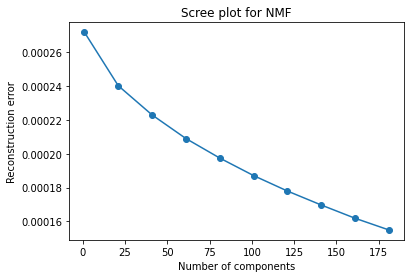

In [ ]:
n_components_range = range(1, 200, 20)
reconstruction_errors = []

for n_components in n_components_range:
    model = NMF(n_components=n_components, random_state=42)
    W = model.fit_transform(X_train_vectors)
    H = model.components_
    X_approx = np.dot(W, H)
    reconstruction_error = np.mean(np.square((X_train_vectors - X_approx).flatten()))
    reconstruction_errors.append(reconstruction_error)

# plot the scree plot
plt.plot(n_components_range, reconstruction_errors, 'o-')
plt.xlabel('Number of components')
plt.ylabel('Reconstruction error')
plt.title('Scree plot for NMF')
plt.show()

In [ ]:
nmf = NMF(n_components=700, random_state=42)
X_train_nmf = nmf.fit_transform(X_train_vectors)
X_test_nmf = nmf.transform(X_test_vectors)

nb = MultinomialNB(alpha=1.4, fit_prior=False)
nb.fit(X_train_nmf, y_train)
y_pred = nb.predict(X_test_nmf)

print_performance(y_test, y_pred)

F1 score:  0.7118506660675337
Accuracy:  0.7047619047619048
MSE:  0.49523809523809526
Confusion matrix: 
[[99 24 10]
 [13 42  3]
 [ 4  8  7]]


Upon evaluation, it appears that utilizing NMF did not result in a significant improvement in model performance.

### Turn NB: Feature Selection with RFE

In [ ]:
n = X_train_vectors.shape[1]
n_features_range = range(900, n, 300)
selected_dict_nb = dict()
for n_features in n_features_range: 
    estimator = LogisticRegression()
    selector = RFE(estimator, n_features_to_select=n_features)
    selector = selector.fit(X_train_vectors, y_train)

    selected_feature_indices = selector.get_support(indices=True)
    selected_train_nb = X_train_vectors[:,selected_feature_indices]
    selected_test_nb = X_test_vectors[:,selected_feature_indices]
    selected_dict_nb[n_features] = selected_feature_indices

    nb = MultinomialNB(alpha=1.4, fit_prior=False)
    nb.fit(selected_train_nb, y_train)
    y_pred = nb.predict(selected_test_nb)
    print(f"Select {n_features} features:")
    print_performance(y_test, y_pred)

Select 900 features:
F1 score:  0.7685126616833934
Accuracy:  0.7619047619047619
MSE:  0.3952380952380952
Confusion matrix: 
[[103  23   7]
 [  6  48   4]
 [  4   6   9]]
Select 1200 features:
F1 score:  0.7933247690968279
Accuracy:  0.7904761904761904
MSE:  0.3523809523809524
Confusion matrix: 
[[111  16   6]
 [  7  47   4]
 [  4   7   8]]
Select 1500 features:
F1 score:  0.798143709468223
Accuracy:  0.7952380952380952
MSE:  0.3476190476190476
Confusion matrix: 
[[112  15   6]
 [  8  46   4]
 [  4   6   9]]
Select 1800 features:
F1 score:  0.7899080106644066
Accuracy:  0.7904761904761904
MSE:  0.3523809523809524
Confusion matrix: 
[[114  14   5]
 [  9  45   4]
 [  5   7   7]]
Select 2100 features:
F1 score:  0.8061560682160743
Accuracy:  0.8095238095238095
MSE:  0.3047619047619048
Confusion matrix: 
[[118  12   3]
 [  9  45   4]
 [  5   7   7]]
Select 2400 features:
F1 score:  0.7952403651280056
Accuracy:  0.8
MSE:  0.34285714285714286
Confusion matrix: 
[[118  11   4]
 [ 10  44   4]


In [ ]:
selected_features_nb = selected_dict_nb[2100]
X_train_updated_nb = X_train_vectors[:,selected_features_nb]
X_test_updated_nb = X_test_vectors[:,selected_features_nb]
X_train_updated_nb.shape, X_test_updated_nb.shape

((1883, 2100), (210, 2100))

In [ ]:
# np.savetxt('selected_features_nb.txt', selected_features_nb, delimiter='\t')
arr_nb = np.loadtxt('selected_features_nb.txt', delimiter='\t')
arr_nb

array([3.000e+00, 4.000e+00, 6.000e+00, ..., 3.517e+03, 3.520e+03,
       3.521e+03])

Our evaluation showed that reducing the number of features in the NB model improved its performance. We have selected **2100 features** as the optimal configuration, achieving an F1 score of 0.806 and an accuracy of 0.810. 

### Final NB with the whole X

In [ ]:
final_nb = MultinomialNB(alpha=1.4, fit_prior=False)
X_updated_nb = X_vectors[:, selected_features_nb]
y_pred = cross_val_predict(final_nb, X_updated_nb, y, cv=5)

print_performance(y, y_pred)

F1 score:  0.8007811848115548
Accuracy:  0.7998088867654085
MSE:  0.38365981844242714
Confusion matrix: 
[[1114   99   80]
 [  57  425   38]
 [  48   97  135]]


After identifying the optimal hyperparameters through grid search and applying feature selection with RFE, we fine-tuned the Naive Bayes model. As a result, we achieved an **F1 score of 0.801** and an **accuracy of 0.800**, indicating a good performance of the model in predicting the target variable.

# Model 2: Random Forest

* Random forest is an ensemble learning method that constructs a multitude of decision trees at training time and outputs the class that is the mode of the classes (classification). 
* It offers advantages such as handling missing values, reducing overfitting, and providing feature importance rankings.

### Baseline of RF

In [ ]:
rf = RandomForestClassifier(n_estimators=100) # 100 trees
rf.fit(X_train_vectors, y_train)
y_pred = rf.predict(X_test_vectors)

print_performance(y_test, y_pred)

F1 score:  0.8138122653693142
Accuracy:  0.8285714285714286
MSE:  0.2714285714285714
Confusion matrix: 
[[128   5   0]
 [ 16  40   2]
 [  7   6   6]]


### Tune RF: Grid search best parameters

In [ ]:
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy', # f1, recall, precision
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_vectors, y_train)
y_pred = grid_search.predict(X_test_vectors)
print_performance(y_test, y_pred)
print("Best hyperparameters: ", grid_search.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
F1 score:  0.8160915039788279
Accuracy:  0.8333333333333334
MSE:  0.28095238095238095
Confusion matrix: 
[[128   5   0]
 [ 15  42   1]
 [  8   6   5]]
Best hyperparameters:  {'max_depth': None, 'max_features': 'auto', 'n_estimators': 500}


### Tune RF: PCA

Text(0, 0.5, 'Cumulative explained variance')

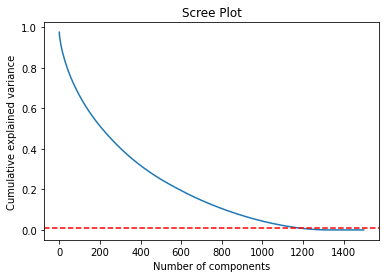

In [ ]:
pca = PCA(n_components=1500)
X_train_pca = pca.fit_transform(X_train_vectors.toarray())
X_test_pca = pca.transform(X_test_vectors.toarray())
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(1-explained_variance)
plt.axhline(y=0.01, color='red', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [ ]:
for i, ratio in enumerate(explained_variance):
  if ratio > .99:
    print(f"k = {i},", f"Explained variance ratio: {ratio*100:.3f}%")
    break

k = 1177, Explained variance ratio: 99.009%


In [11]:
pca = PCA(n_components=1177)
X_train_vectors_pca = pca.fit_transform(X_train_vectors.toarray())
X_test_vectors_pca = pca.transform(X_test_vectors.toarray())

rf = RandomForestClassifier(max_features='auto', n_estimators=500, random_state=42)
rf.fit(X_train_vectors_pca, y_train)
y_pred = rf.predict(X_test_vectors_pca)

print_performance(y_test, y_pred)

F1 score:  0.6870563274717
Accuracy:  0.7380952380952381
MSE:  0.46190476190476193
Confusion matrix: 
[[133   0   0]
 [ 40  18   0]
 [ 14   1   4]]


To determine the optimal number of components for PCA, we utilized a scree plot and identified a value of k=1177 that explained a variance ratio greater than 99%. However, we did not observe an improvement in the performance of our baseline Random Forest model when incorporating PCA.

### Turn RF: Feature Selection with RFE

Here we use a decision tree-based model as the estimator for the RFE selector, since decision trees and Random Forests have a natural way of ranking the importance of features.

In [ ]:
n = X_train_vectors.shape[1]
n_features_range = range(1200, n, 300)
selected_dict_rf = dict()
for n_features in n_features_range: 
    estimator = DecisionTreeClassifier(random_state=42)
    selector = RFE(estimator, n_features_to_select=n_features)
    selector = selector.fit(X_train_vectors, y_train)

    selected_feature_indices = selector.get_support(indices=True)
    selected_train_rf = X_train_vectors[:,selected_feature_indices]
    selected_test_rf = X_test_vectors[:,selected_feature_indices]
    selected_dict_rf[n_features] = selected_feature_indices

    rf = RandomForestClassifier(max_features='auto', n_estimators=500, random_state=42)
    rf.fit(selected_train_rf, y_train)
    y_pred = rf.predict(selected_test_rf)
    print(f"Select {n_features} features:")
    print_performance(y_test, y_pred)

Select 1200 features:
F1 score:  0.8225714814725154
Accuracy:  0.8380952380952381
MSE:  0.2761904761904762
Confusion matrix: 
[[128   5   0]
 [ 12  43   3]
 [  8   6   5]]
Select 1500 features:
F1 score:  0.830991437000125
Accuracy:  0.8428571428571429
MSE:  0.2714285714285714
Confusion matrix: 
[[128   5   0]
 [ 14  42   2]
 [  8   4   7]]
Select 1800 features:
F1 score:  0.8361097295139847
Accuracy:  0.8476190476190476
MSE:  0.26666666666666666
Confusion matrix: 
[[128   5   0]
 [ 13  43   2]
 [  8   4   7]]
Select 2100 features:
F1 score:  0.8361097295139847
Accuracy:  0.8476190476190476
MSE:  0.26666666666666666
Confusion matrix: 
[[128   5   0]
 [ 13  43   2]
 [  8   4   7]]
Select 2400 features:
F1 score:  0.8190083911638684
Accuracy:  0.8333333333333334
MSE:  0.26666666666666666
Confusion matrix: 
[[128   5   0]
 [ 15  41   2]
 [  7   6   6]]
Select 2700 features:
F1 score:  0.821174611187231
Accuracy:  0.8380952380952381
MSE:  0.2761904761904762
Confusion matrix: 
[[128   5   0

In [ ]:
selected_features_rf = selected_dict_rf[1800]
X_train_updated_rf = X_train_vectors[:,selected_features_rf]
X_test_updated_rf = X_test_vectors[:,selected_features_rf]
X_train_updated_rf.shape, X_test_updated_rf.shape

((1883, 1800), (210, 1800))

In [ ]:
# np.savetxt('selected_features_rf.txt', selected_features_rf, delimiter='\t')
arr_rf = np.loadtxt('selected_features_rf.txt', delimiter='\t')
arr_rf

array([  50.,   51.,   52., ..., 3499., 3500., 3501.])

The results of the feature selection analysis demonstrate that the 1800 selected features have significantly improved the performance of the Random Forest (RF) model. The F1 score of the model has increased to 0.836 and the accuracy has improved to 0.848.

###  Final RF with the whole X

In [ ]:
final_rf = RandomForestClassifier(max_features='auto', n_estimators=500, random_state=42)
X_updated_rf = X_vectors[:, selected_features_rf]
y_pred = cross_val_predict(final_rf, X_updated_rf, y, cv=5)

print_performance(y, y_pred)

F1 score:  0.82145476297931
Accuracy:  0.8361204013377926
MSE:  0.3129479216435738
Confusion matrix: 
[[1247   42    4]
 [ 102  399   19]
 [ 100   76  104]]


To improve the performance of our RF model, we carefully selected 1800 features and optimized the model using them. We then conducted cross-validation on the entire training set, which resulted in an impressive **F1 score of 0.821** and an **accuracy of 0.836**.

# Model 3: SVMs (`Support Vector Machines`)
* SVM works by finding the optimal boundary or hyperplane that maximizes the margin between classes in high-dimensional feature space. 
* It is pretty useful for handling non-linearly separable data through the use of kernel functions.

### Baseline of SVM

In [ ]:
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train_vectors, y_train)
y_pred = svm.predict(X_test_vectors)

print_performance(y_test, y_pred)

F1 score:  0.7839776769810899
Accuracy:  0.8
MSE:  0.35714285714285715
Confusion matrix: 
[[127   5   1]
 [ 23  34   1]
 [ 10   2   7]]


### Tune SVM: Grid search best parameters

In [ ]:
svm = SVC(random_state=42)
param_grid = {
    'C': [None, 0.1, 0.5, 1, 5, 10, 20],
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': ['scale', 'auto'],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5)
grid_search.fit(X_train_vectors, y_train)
y_pred = grid_search.predict(X_test_vectors)

print_performance(y_test, y_pred)
print("Best hyperparameters: ", grid_search.best_params_)

F1 score:  0.8104821374120982
Accuracy:  0.8238095238095238
MSE:  0.3333333333333333
Confusion matrix: 
[[128   3   2]
 [ 19  38   1]
 [  9   3   7]]
Best hyperparameters:  {'C': 5, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear'}


### Tune SVM: PCA

In [ ]:
pca = PCA(n_components=1177) # chosen by PCA via screen plot in the chapter of Random Forest
X_train_vectors_pca = pca.fit_transform(X_train_vectors.toarray())
X_test_vectors_pca = pca.transform(X_test_vectors.toarray())

svm = SVC(C=5, gamma='scale', kernel='linear', random_state=42)
svm.fit(X_train_vectors_pca, y_train)
y_pred = svm.predict(X_test_vectors_pca)

print_performance(y_test, y_pred)

F1 score:  0.8127428193499622
Accuracy:  0.8285714285714286
MSE:  0.3
Confusion matrix: 
[[129   3   1]
 [ 18  39   1]
 [  8   5   6]]


PCA seem to do enhance its performance a little bit, we decided to stick with the first 1177 features for simplicity's sake. (k=1177 is the boundary for keeping 99% variance)

### Turn SVM: Feature Selection with RFE

In [ ]:
n_features_range = range(400, 1200, 300)
selected_dict_svm = dict()
for n_features in n_features_range: 
    estimator = SVC(C=5, gamma='scale', kernel='linear', random_state=42)
    selector = RFE(estimator, n_features_to_select=n_features)
    selector = selector.fit(X_train_vectors_pca, y_train)

    selected_feature_indices = selector.get_support(indices=True)
    selected_train_svm = X_train_vectors_pca[:,selected_feature_indices]
    selected_test_svm = X_test_vectors_pca[:,selected_feature_indices]
    selected_dict_svm[n_features] = selected_feature_indices

    svm = SVC(C=5, gamma='scale', kernel='linear', random_state=42)
    svm.fit(selected_train_svm, y_train)
    y_pred = svm.predict(selected_test_svm)
    print(f"Select {n_features} features:")
    print_performance(y_test, y_pred)

Select 400 features:
F1 score:  0.780184171090599
Accuracy:  0.7952380952380952
MSE:  0.319047619047619
Confusion matrix: 
[[126   6   1]
 [ 22  34   2]
 [  7   5   7]]
Select 700 features:
F1 score:  0.8060262811436519
Accuracy:  0.819047619047619
MSE:  0.26666666666666666
Confusion matrix: 
[[127   5   1]
 [ 19  38   1]
 [  5   7   7]]
Select 1000 features:
F1 score:  0.8104321548580002
Accuracy:  0.8238095238095238
MSE:  0.319047619047619
Confusion matrix: 
[[128   3   2]
 [ 19  38   1]
 [  8   4   7]]


After applying PCA, the number of features in the dataset is reduced to a smaller set of principal components that explain most of the variance in the data. Therefore, it is not necessary to reduce the number of features further, as this would result in a loss of information.

###  Final SVM with the whole X

In [ ]:
pca = PCA(n_components=1177)
X_vectors_pca_svm = pca.fit_transform(X_vectors.toarray())

final_svm = SVC(C=5, gamma='scale', kernel='linear', random_state=42)
y_pred = cross_val_predict(final_svm, X_vectors_pca_svm, y, cv=5)

print_performance(y, y_pred)

F1 score:  0.8253527203080023
Accuracy:  0.8346870520783565
MSE:  0.3129479216435738
Confusion matrix: 
[[1240   35   18]
 [ 122  370   28]
 [  85   58  137]]


Our final SVM model, optimized with PCA method and tuned hyperparameters (C=5, gamma='scale', kernel='linear'), yielded impressive results on the entire training set. The combined approach resulted in an **F1 score of 0.825** and an **accuracy of 0.835**, indicating that our model is well-suited for the given dataset.

# Model 4: Logistic Regression
* Logistic Regression is commonly used for binary classification problems. 
* It estimates the parameters of a logistic function to map the input features to the predicted probabilities, and it can be extended to handle multi-class classification problems through techniques such as one-vs-all or softmax regression.

### Baseline of LR

In [ ]:
lr = LogisticRegression(multi_class='multinomial')
lr.fit(X_train_vectors, y_train)
y_pred = lr.predict(X_test_vectors)

print_performance(y_test, y_pred)

F1 score:  0.7352717652717653
Accuracy:  0.7714285714285715
MSE:  0.42857142857142855
Confusion matrix: 
[[131   2   0]
 [ 30  28   0]
 [ 14   2   3]]


### Tune LR: Grid search best parameters

In [ ]:
lr = LogisticRegression(multi_class='multinomial')
param_grid = {
    'C': [None, 0.1, 0.5, 1, 5, 10],
    'penalty': [None, 'l1', 'l2'],
    'solver': [None, 'lbfgs', 'liblinear', 'saga']
}

grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5)
grid_search.fit(X_train_vectors, y_train)
y_pred = grid_search.predict(X_test_vectors)

print_performance(y_test, y_pred)
print("Best hyperparameters: ", grid_search.best_params_)

F1 score:  0.812218986198578
Accuracy:  0.8285714285714286
MSE:  0.3142857142857143
Confusion matrix: 
[[131   2   0]
 [ 22  36   0]
 [ 10   2   7]]
Best hyperparameters:  {'C': 5, 'penalty': 'l2', 'solver': 'lbfgs'}


### Tune LR: PCA

In [ ]:
pca = PCA(n_components=1177) # chosen by PCA via screen plot in the chapter of Random Forest
X_train_vectors_pca = pca.fit_transform(X_train_vectors.toarray())
X_test_vectors_pca = pca.transform(X_test_vectors.toarray())

lr = LogisticRegression(C=5, penalty='l2', solver='lbfgs', random_state=42)
lr.fit(X_train_vectors_pca, y_train)
y_pred = lr.predict(X_test_vectors_pca)

print_performance(y_test, y_pred)

F1 score:  0.7979024490888897
Accuracy:  0.8142857142857143
MSE:  0.32857142857142857
Confusion matrix: 
[[129   4   0]
 [ 23  35   0]
 [ 10   2   7]]


Based on our analysis, it seems that PCA does not provide any benefits for our logistic regression model.

### Turn LR: Feature Selection with RFE

In [ ]:
n_features_range = range(400, 1200, 300)
selected_dict_lr = dict()
for n_features in n_features_range: 
    estimator = LogisticRegression(random_state=42)
    selector = RFE(estimator, n_features_to_select=n_features)
    selector = selector.fit(X_train_vectors, y_train)

    selected_feature_indices = selector.get_support(indices=True)
    selected_train_lr = X_train_vectors[:,selected_feature_indices]
    selected_test_lr = X_test_vectors[:,selected_feature_indices]
    selected_dict_lr[n_features] = selected_feature_indices

    lr = LogisticRegression(C=5, penalty='l2', solver='lbfgs', random_state=42)
    lr.fit(selected_train_lr, y_train)
    y_pred = lr.predict(selected_test_lr)
    print(f"Select {n_features} features:")
    print_performance(y_test, y_pred)

Select 400 features:
F1 score:  0.7437640825928378
Accuracy:  0.7714285714285715
MSE:  0.44285714285714284
Confusion matrix: 
[[127   5   1]
 [ 24  32   2]
 [ 14   2   3]]
Select 700 features:
F1 score:  0.7802698183650564
Accuracy:  0.8
MSE:  0.38571428571428573
Confusion matrix: 
[[128   4   1]
 [ 21  35   2]
 [ 12   2   5]]
Select 1000 features:
F1 score:  0.7956826421717462
Accuracy:  0.8142857142857143
MSE:  0.34285714285714286
Confusion matrix: 
[[130   3   0]
 [ 21  35   2]
 [ 11   2   6]]


For the sake of simplicity, we would not keep to use RFE in LR as well.

### Final LR with the whole X

In [ ]:
final_lr = LogisticRegression(multi_class='multinomial', C=5, penalty='l2', 
                             solver='lbfgs', random_state=42)
y_pred = cross_val_predict(final_lr, X_vectors, y, cv=5)

print_performance(y, y_pred)

F1 score:  0.8208211939649664
Accuracy:  0.8351648351648352
MSE:  0.32823698041089344
Confusion matrix: 
[[1271   17    5]
 [ 149  357   14]
 [ 109   51  120]]


We have optimized the LR model with hyperparameters C=5, penalty='l2', and solver='lbfgs'. The resulting **F1 score was 0.821**, and the **accuracy was 0.835**, indicating that the model is performing well on the given dataset.

# Model 5: AdaBoost (`Adaptive Boosting`)

*  AdaBoost works by combining multiple weak classifiers into a strong classifier through iterative training. 
* In each iteration, the algorithm assigns higher weights to the incorrectly classified samples and lower weights to the correctly classified ones, thus focusing on the more difficult samples in subsequent iterations.

### Baseline of Ada

In [ ]:
dtc = DecisionTreeClassifier(max_depth=2)
ada = AdaBoostClassifier(base_estimator=dtc, random_state=42)
ada.fit(X_train_vectors, y_train)
y_pred = ada.predict(X_test_vectors)

print_performance(y_test, y_pred)

F1 score:  0.7936480386547142
Accuracy:  0.8095238095238095
MSE:  0.3476190476190476
Confusion matrix: 
[[126   5   2]
 [ 17  39   2]
 [  9   5   5]]


### Tune Ada: Grid search best parameters

In [ ]:
max_depth_list = [10] # already tested [None, 5, 10]
for max_depth in max_depth_list:
    dtc = DecisionTreeClassifier(max_depth=max_depth) 
    ada = AdaBoostClassifier(base_estimator=dtc, random_state=42)
    param_grid = {'learning_rate': [0.01, 0.1, 0.5, 1],
                  'n_estimators': [50, 100, 200, 500]}

    grid_search = GridSearchCV(estimator=ada, param_grid=param_grid, cv=5)
    grid_search.fit(X_train_vectors, y_train)
    y_pred = grid_search.predict(X_test_vectors)
    
    print_performance(y_test, y_pred)
    print("Best hyperparameters: ", grid_search.best_params_)

F1 score:  0.827559758655165
Accuracy:  0.8380952380952381
MSE:  0.24761904761904763
Confusion matrix: 
[[130   3   0]
 [ 14  38   6]
 [  6   5   8]]
Best hyperparameters:  {'learning_rate': 0.1, 'n_estimators': 200}


After comparing the results, we found that using a learning rate of 0.1 and 200 estimators, along with a maximum decision tree depth of 10, yielded the best performance.

### Tune Ada: PCA

In [ ]:
pca = PCA(n_components=1177) # chosen by PCA via screen plot in the chapter of Random Forest
X_train_vectors_pca = pca.fit_transform(X_train_vectors.toarray())
X_test_vectors_pca = pca.transform(X_test_vectors.toarray())

dtc = DecisionTreeClassifier(max_depth=10)
ada = AdaBoostClassifier(base_estimator=dtc, learning_rate=.1, n_estimators=200, random_state=42)
ada.fit(X_train_vectors_pca, y_train)
y_pred = ada.predict(X_test_vectors_pca)

print_performance(y_test, y_pred)

F1 score:  0.812344214106382
Accuracy:  0.8238095238095238
MSE:  0.2904761904761905
Confusion matrix: 
[[126   6   1]
 [ 16  40   2]
 [  7   5   7]]


PCA does not seem to improve the performance of the AdaBoost algorithm significantly.

### Turn Ada: Feature Selection with RFE

In [12]:
n_features_range = [900] # already tested range(400, 1200, 300)
selected_dict_ada = dict()
for n_features in n_features_range: 
    estimator = LogisticRegression()
    selector = RFE(estimator, n_features_to_select=n_features)
    selector = selector.fit(X_train_vectors_pca, y_train)

    selected_feature_indices = selector.get_support(indices=True)
    selected_train_ada = X_train_vectors_pca[:,selected_feature_indices]
    selected_test_ada = X_test_vectors_pca[:,selected_feature_indices]
    selected_dict_ada[n_features] = selected_feature_indices

    dtc = DecisionTreeClassifier(max_depth=10)
    ada = AdaBoostClassifier(base_estimator=dtc, learning_rate=.1, n_estimators=200, random_state=42)
    ada.fit(selected_train_ada, y_train)
    y_pred = ada.predict(selected_test_ada)
    print(f"Select {n_features} features:")
    print_performance(y_test, y_pred)

Select 900 features:
F1 score:  0.7664506569751188
Accuracy:  0.7857142857142857
MSE:  0.34285714285714286
Confusion matrix: 
[[127   5   1]
 [ 24  32   2]
 [  8   5   6]]


Same, the other feature selection method does not work for Ada as well.

### Final Ada with the whole X

In [ ]:
dtc = DecisionTreeClassifier(max_depth=10, random_state=42)
final_ada = AdaBoostClassifier(base_estimator=dtc, learning_rate=.1, n_estimators=200, random_state=42)
y_pred = cross_val_predict(final_ada, X_vectors, y, cv=5)

print_performance(y, y_pred)

F1 score:  0.8164610224165573
Accuracy:  0.8265647396082179
MSE:  0.3110367892976589
Confusion matrix: 
[[1228   48   17]
 [ 103  382   35]
 [  79   81  120]]


We used the optimal hyperparameters obtained through grid searching to update the AdaBoost model, neither PCA or RFE can help to improve its performance. The model achieved an **F1 score of 0.816** and **accuracy of 0.827** on the whole training set with 5-fold cross-validation.

# Model 6: NLPaug + ML models
* [NLPaug](https://nlpaug.readthedocs.io/en/latest/augmenter/augmenter.html) is a data augmentation technique for NLP that enhances the training data by generating synthetic examples. **Although it is not a ML model, we combine it with other classification models to create a comprehensive ML model. Thus, we refer to the combination of NLPaug and any other models as a ML model for the sake of simplicity.**
* It provides a wide range of data augmentation techniques for natural language processing tasks, which can help improve the performance of machine learning models by increasing the amount of training data available, enhancing the diversity of the data, and reducing overfitting. 
* NLPaug supports various augmentation operations, such as word and character-level replacements, synonym replacement, OCR-like augmentations, and more.

In [14]:
# !pip install nlpaug

In [15]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.flow as naf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

### Build an augmentation pipeline

Here we use two augmentation technique in pipeline, then train different classifiers on the augmented data:

* KeyboardAug is a type of augmentation that simulates keyboard typing errors and is used to increase the robustness of text data by introducing variations. This augmentation randomly adds, deletes, or replaces characters in the text.

* SynonymAug, on the other hand, replaces words in the text with their synonyms to increase the diversity of the data and improve the model's ability to generalize to unseen data.


In [ ]:
# Create an aug object for character-level augmentation
aug1 = nac.KeyboardAug()
aug2 = naw.SynonymAug()

# Create an augmentation pipeline
aug_pipeline = naf.Sequential([aug1, aug2])

# Augment the training data
X_train_augmented = []
y_train_augmented = []

for text, label in zip(X_train, y_train):
    for _ in range(5): # Augment each sentence by 5 times
        augmented_text = aug_pipeline.augment(text)
        if augmented_text:
          X_train_augmented.append(augmented_text[0])
        else: X_train_augmented.append('')
        y_train_augmented.append(label)

# Combine the original data with the augmented data
X_train_combined = pd.concat([X_train, pd.Series(X_train_augmented)])
y_train_combined = pd.concat([y_train, pd.Series(y_train_augmented)])

# Vectorize the text data
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train_combined)
X_test_vectorized = vectorizer.transform(X_test)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### Combine with ML models

Next, we will combine each model's "best fit format" with our augmentation pipeline to compare the combinations' performance. By doing so, we can accurately compare their performance and select the most suitable model for our specific use case.

In [ ]:
# Train a Naive Bayes classifier on the augmented data
classifier = MultinomialNB(alpha=1.4, fit_prior=False)
classifier.fit(X_train_vectorized, y_train_combined)
y_pred = classifier.predict(X_test_vectorized)

print_performance(y_test, y_pred)

F1 score:  0.7778923751886981
Accuracy:  0.7952380952380952
MSE:  0.319047619047619
Confusion matrix: 
[[129   4   0]
 [ 22  30   6]
 [  8   3   8]]


In [ ]:
# Train a Random Forest classifier on the augmented data
classifier = RandomForestClassifier(max_features='auto', n_estimators=500, random_state=42)
classifier.fit(X_train_vectorized, y_train_combined)
y_pred = classifier.predict(X_test_vectorized)

print_performance(y_test, y_pred)

F1 score:  0.815963249572501
Accuracy:  0.819047619047619
MSE:  0.23809523809523808
Confusion matrix: 
[[119  12   2]
 [ 11  45   2]
 [  2   9   8]]


In [ ]:
# Train a SVM classifier on the augmented data
classifier = SVC(C=5, gamma='scale', kernel='linear', random_state=42)
classifier.fit(X_train_vectorized, y_train_combined)
y_pred = classifier.predict(X_test_vectorized)

print_performance(y_test, y_pred)

F1 score:  0.8411714471363595
Accuracy:  0.8428571428571429
MSE:  0.2571428571428571
Confusion matrix: 
[[121   8   4]
 [ 13  44   1]
 [  3   4  12]]


In [ ]:
# Train a Logistic regression classifier on the augmented data
classifier = LogisticRegression(multi_class='multinomial', C=5, penalty='l2', 
                                solver='lbfgs', random_state=42)
classifier.fit(X_train_vectorized, y_train_combined)
y_pred = classifier.predict(X_test_vectorized)

print_performance(y_test, y_pred)

F1 score:  0.8504236090571495
Accuracy:  0.8523809523809524
MSE:  0.20476190476190476
Confusion matrix: 
[[123   8   2]
 [ 12  44   2]
 [  2   5  12]]


In [ ]:
# Train a AdaBoost classifier on the augmented data
dtc = DecisionTreeClassifier(max_depth=10, random_state=42)
classifier = AdaBoostClassifier(base_estimator=dtc, learning_rate=.1, 
                                n_estimators=200, random_state=42)
classifier.fit(X_train_vectorized, y_train_combined)
y_pred = classifier.predict(X_test_vectorized)

print_performance(y_test, y_pred)

F1 score:  0.8234498801963385
Accuracy:  0.8238095238095238
MSE:  0.2904761904761905
Confusion matrix: 
[[120   8   5]
 [ 11  43   4]
 [  3   6  10]]


Based on the performance of the five classification models on the augmented data, we have decided to use the optimized Logistic Regression model to combine with the augmentation technique as the final one. This model achieved an **F1 score of 0.850** and an **accuracy of 0.852**.

# Application: Ensemble Learning with Combined Votes of 6 Text Classification Models

### Ensemble classification of labeled data using multiple models

I combined the six text classification models into a single function, trained it on the training set, and evaluated its performance on the test set. The ensemble model uses the mode of votes from these models to classify text. The results were impressive, achieving an **F1 score of 0.851** and an **accuracy of 0.862**. These scores outperformed any single model used before.

In [ ]:
def merge_models(X_train_vectors, X_new_vectors, X_train, X_new, y_train,
                 selected_features_nb, selected_features_rf):
    # final naive bayes
    X_new_updated_nb = X_new_vectors[:, selected_features_nb]
    final_nb = MultinomialNB(alpha=1.4, fit_prior=False)
    X_updated_nb = X_train_vectors[:, selected_features_nb]
    final_nb.fit(X_updated_nb, y_train)
    y_pred_nb = final_nb.predict(X_new_updated_nb)

    # final random forest
    X_new_updated_rf = X_new_vectors[:, selected_features_rf]
    final_rf = RandomForestClassifier(max_features='auto', n_estimators=500, random_state=42)
    X_updated_rf = X_train_vectors[:, selected_features_rf]
    final_rf.fit(X_updated_rf, y_train)
    y_pred_rf = final_rf.predict(X_new_updated_rf)

    # final SVM
    pca = PCA(n_components=1177)
    X_train_vectors_pca_svm = pca.fit_transform(X_train_vectors.toarray())
    X_new_updated_pca_svm = pca.transform(X_new_vectors.toarray())
    final_svm = SVC(C=5, gamma='scale', kernel='linear', random_state=42)
    final_svm.fit(X_train_vectors_pca_svm, y_train)
    y_pred_svm = final_svm.predict(X_new_updated_pca_svm)

    # final Logistic Regression
    final_lr = LogisticRegression(multi_class='multinomial', C=5, penalty='l2', 
                                  solver='lbfgs', random_state=42)
    final_lr.fit(X_train_vectors, y_train)
    y_pred_lr = final_lr.predict(X_new_vectors)

    # final AdaBoost
    dtc = DecisionTreeClassifier(max_depth=10)
    final_ada = AdaBoostClassifier(base_estimator=dtc, learning_rate=.1, 
                                   n_estimators=200, random_state=42)
    final_ada.fit(X_train_vectors, y_train)
    y_pred_ada = final_ada.predict(X_new_vectors)

    # augmentation with LR
    aug1 = nac.KeyboardAug()
    aug2 = naw.SynonymAug()
    aug_pipeline = naf.Sequential([aug1, aug2])

    X_train_augmented = []
    y_train_augmented = []
    for text, label in zip(X_train, y_train):
        for _ in range(5): 
            augmented_text = aug_pipeline.augment(text)
            if augmented_text:
              X_train_augmented.append(augmented_text[0])
            else: X_train_augmented.append('')
            y_train_augmented.append(label)
    X_train_combined = pd.concat([X_train, pd.Series(X_train_augmented)])
    y_train_combined = pd.concat([y_train, pd.Series(y_train_augmented)])

    vectorizer = CountVectorizer()
    X_train_vectorized = vectorizer.fit_transform(X_train_combined)
    X_test_vectorized = vectorizer.transform(X_new)
    classifier = LogisticRegression(multi_class='multinomial', C=5, penalty='l2', 
                                    solver='lbfgs', random_state=42)
    classifier.fit(X_train_vectorized, y_train_combined)
    y_pred_aug = classifier.predict(X_test_vectorized)

    return y_pred_nb, y_pred_rf, y_pred_svm, y_pred_lr, y_pred_ada, y_pred_aug

In [ ]:
selected_features_nb = np.loadtxt('selected_features_nb.txt', delimiter='\t')
selected_features_rf = np.loadtxt('selected_features_rf.txt', delimiter='\t')
y_pred_nb, y_pred_rf, y_pred_svm, y_pred_lr, y_pred_ada, y_pred_aug = merge_models(X_train_vectors, X_test_vectors, 
                                                                                   X_train, X_test, y_train,
                                                                                   selected_features_nb, selected_features_rf)

In [ ]:
len(y_pred_nb), len(y_pred_rf), len(y_pred_svm), len(y_pred_lr), len(y_pred_ada), len(y_pred_aug)

(210, 210, 210, 210, 210, 210)

In [ ]:
target = []
for i in range(len(y_pred_nb)):
    temp = Counter([y_pred_nb[i], y_pred_rf[i], y_pred_svm[i], y_pred_lr[i], y_pred_ada[i], y_pred_aug[i]]).most_common(1)
    target.append(temp)
len(target)

210

In [ ]:
y_pred = [i[0][0] for i in target]
print_performance(y_test, y_pred)

F1 score:  0.8506447453255964
Accuracy:  0.861904761904762
MSE:  0.26666666666666666
Confusion matrix: 
[[129   4   0]
 [ 11  45   2]
 [  9   3   7]]


### Predicting unlabeled data with the ensemble model

Next, we will utilize the ensemble model to predict the categories of an unlabeled subset, which is a slice of the unlabeled dataset with indices ranging from 40,000 to 80,000.

In [ ]:
new = pd.read_csv("../filtered.csv")
new['tokenized_tweets'] = new['content'].apply(lambda x: text_clean_and_tokenize(x))
new[['tokenized', 'merged']] = new['tokenized_tweets'].apply(lambda x: pd.Series(x))
new['created_datetime'] = pd.to_datetime(new['created_datetime'])
new.head()

,Unnamed: 0,index,tweet_id,created_datetime,content,author_id,place_id,location,longitude,latitude,county,tokenized_tweets,tokenized,merged
0,0,0,1.000014e+17,2011-08-07,Bear Grylls just bit a trout's head off!,18003609.0,fbd6d2f5a4e4a15e,"California, USA",-120.645800,35.247868,SAN LUIS OBISPO,"([bear, grylls, bit, trout, head], bear grylls...","[bear, grylls, bit, trout, head]",bear grylls bit trout head
1,1,1,1.000016e+18,2018-05-25,@StacyGSG love the Jets t-shirt on the bear,596144748.0,a592bd6ceb1319f7,"San Diego, CA",-117.109730,32.801037,SAN DIEGO,"([love, jet, shirt, bear], love jet shirt bear)","[love, jet, shirt, bear]",love jet shirt bear
2,2,2,1.000017e+18,2018-05-25,Kid: what is this this is boring. I wish it wa...,31197211.0,0c2e6999105f8070,"Anaheim, CA",-117.829060,33.810070,ORANGE,"([kid, boring, wish, mickey, mouse, club, pare...","[kid, boring, wish, mickey, mouse, club, paren...",kid boring wish mickey mouse club parent quiet...
3,5,5,1.000040e+17,2011-08-07,Making hubby jealous (@ Big Bear Valley Sports...,19245601.0,17fe6350a3570c69,"Big Bear Lake, CA",-116.866684,34.259740,SAN BERNARDINO,"([making, hubby, jealous, big, bear, valley, s...","[making, hubby, jealous, big, bear, valley, sp...",making hubby jealous big bear valley sportsman...
4,7,7,1.000055e+18,2018-05-25,Yep. Only one Bear. https://t.co/WfUOioWGmd,415006664.0,fbd6d2f5a4e4a15e,"California, USA",-119.311030,37.250366,MADERA,"([yep, one, bear], yep one bear)","[yep, one, bear]",yep one bear


In [ ]:
new_sub = new.iloc[40000: 80000].copy()
X_new = new_sub['merged']

X_new_vectors = tfidf.transform(X_new)
X_new_vectors.shape

(40000, 3524)

In [ ]:
selected_features_nb = np.loadtxt('selected_features_nb.txt', delimiter='\t')
selected_features_rf = np.loadtxt('selected_features_rf.txt', delimiter='\t')
y_pred_nb, y_pred_rf, y_pred_svm, y_pred_lr, y_pred_ada, y_pred_aug = merge_models(X_vectors, X_new_vectors, X, X_new, y,
                                                                                   selected_features_nb, selected_features_rf)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
new_sub['y_pred_nb'] = y_pred_nb
new_sub['y_pred_rf'] = y_pred_rf
new_sub['y_pred_svm'] = y_pred_svm
new_sub['y_pred_lr'] = y_pred_lr
new_sub['y_pred_ada'] = y_pred_ada
new_sub['y_pred_aug'] = y_pred_aug
# new_sub.to_csv(f'../test_labels.csv', index=False)

To obtain a combined prediction, we appended the predictions generated by each of the six models to the existing dataframe. We then calculated the mode of these predictions, which we saved as a new column in the dataframe. The following example provides a clear illustration of the format by providing the records that were predicted as 1 by **at least 4 models (threshold)**:

In [ ]:
target_labels = ['y_pred_nb','y_pred_rf','y_pred_svm','y_pred_lr','y_pred_ada','y_pred_aug']
vote = []
for i in range(len(new_sub)):
    temp = new_sub.iloc[i][target_labels]
    vote.append(Counter(temp).most_common())

new_sub['vote'] = vote
new_sub.to_csv(f'../test_labels.csv', index=False)

In [ ]:
l, r = 5500, 6000
for i in range(l, r):
  votes = dict(new_sub.iloc[i].vote)
  try:
    if votes[1] >= 4:
        print(i, votes, new_sub.iloc[i].content)
  except: continue

5513 {1: 6} #drinklocal #craftbeer #beerporn #craftbeerguy #drinkcraft @pizzaportcarlsbad Rippin Bear #collaboration with @esbcbrews #cacraftbeer #independentbeer #supportlocalbeer #supportcraftbeer #properpour #properglassware https://t.co/cle0iL5oX7
5523 {1: 6} “THERE WAS ONE MATCH!” said Grumpy Bear. https://t.co/uwQCUBLyCJ https://t.co/N1ECMITNrb
5525 {1: 6} @CShalby Big Bear or one of the little lakes around Tahoe? Very pretty 🤩
5526 {1: 6} There's a bear in this picture. #WannaGetAway #Yosemite National Park https://t.co/EAyD12hxn5
5545 {1: 5, 2: 1} @RagingWaters Does a bear sh*t in the woods? #yes
5556 {1: 4, 0: 2} @sundayjeff I vividly remember the care bear craze and my parents getting me Lucky and my brorhers and sisters other ones.  I had to of been about 7 https://t.co/e8k969Wc8h
5562 {1: 6} @DeborahNetburn @DeborahNetburn whattaabout this bear of a bear 😌
5568 {1: 4, 0: 2} As the world warms &amp; Arctic sea ice thins, starving polar bears are being driven ever further sou

### Implementing an ensemble model to generate a target subset for manual labeling by CDFW

Using ensemble model votes from 6 text classification models, we can automatically predict the labels for unlabeled data and create a subset of records predicted as 1 or 2. This subset can then be sent to CDFW environmental scientists for manual labeling. 

This approach is highly efficient as **it significantly narrows down the range of data and improves the handling of imbalanced data (only ~5% class 1 data)**, ultimately saving time and resources required for manual labeling. On the other hand, having the dataset labeled by CDFW Environmental Scientists would result in a higher level of accuracy and greatly improve the reliability of the entire pipeline and ensemble model.

In [ ]:
unlabeled = pd.read_csv('../test_labels.csv')
labeled = merge_csv()

In [ ]:
unlabeled.info(), labeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        40000 non-null  int64  
 1   index             40000 non-null  int64  
 2   tweet_id          40000 non-null  float64
 3   created_datetime  40000 non-null  object 
 4   content           40000 non-null  object 
 5   author_id         40000 non-null  float64
 6   place_id          37355 non-null  object 
 7   location          37355 non-null  object 
 8   longitude         40000 non-null  float64
 9   latitude          40000 non-null  float64
 10  county            40000 non-null  object 
 11  tokenized_tweets  40000 non-null  object 
 12  tokenized         40000 non-null  object 
 13  merged            39955 non-null  object 
 14  y_pred_nb         40000 non-null  int64  
 15  y_pred_rf         40000 non-null  int64  
 16  y_pred_svm        40000 non-null  int64 

(None, None)

#### Here, we are assigning unique labels to each record by taking the mode of the 6 models' prediction votes. This process applies to text data, and ensures consistency and accuracy in labeling.

In [ ]:
import ast

def extract_first_value(lst):
    if isinstance(lst, str):
        lst = ast.literal_eval(lst)
    if isinstance(lst, list) and len(lst) > 0:
        return lst[0][0]
    else:
        return np.nan

In [ ]:
concatenated_df = pd.concat([unlabeled, labeled], axis=0)
concatenated_df.drop_duplicates(subset=['tweet_id','content'], inplace=True)
concatenated_df['label'] = concatenated_df['label'].fillna(concatenated_df['vote'].apply(extract_first_value))
concatenated_df.drop(['Unnamed: 0','index','tokenized_tweets', 'tokenized', 'merged'], axis=1, inplace=True)
concatenated_df.count()

tweet_id            46888
created_datetime    46888
content             46888
author_id           46888
place_id            44088
location            44086
longitude           46888
latitude            46888
county              46888
y_pred_nb           40000
y_pred_rf           40000
y_pred_svm          40000
y_pred_lr           40000
y_pred_ada          40000
y_pred_aug          40000
vote                40000
label               46888
dtype: int64

To avoid any disturbance, I have dropped any records that are unrelated to labelling and have only kept four necessary features: tweet_id, created_datetime, county, and content.

In [ ]:
true_labels_labeled = concatenated_df.loc[concatenated_df['label']>0].copy()
true_labels_labeled = true_labels_labeled.reset_index(drop=True)
true_labels_unlabeled = true_labels_labeled[['tweet_id','created_datetime','county','content']].copy()
true_labels_labeled.info(), true_labels_unlabeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8843 entries, 0 to 8842
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tweet_id          8843 non-null   float64
 1   created_datetime  8843 non-null   object 
 2   content           8843 non-null   object 
 3   author_id         8843 non-null   float64
 4   place_id          8660 non-null   object 
 5   location          8660 non-null   object 
 6   longitude         8843 non-null   float64
 7   latitude          8843 non-null   float64
 8   county            8843 non-null   object 
 9   y_pred_nb         7792 non-null   float64
 10  y_pred_rf         7792 non-null   float64
 11  y_pred_svm        7792 non-null   float64
 12  y_pred_lr         7792 non-null   float64
 13  y_pred_ada        7792 non-null   float64
 14  y_pred_aug        7792 non-null   float64
 15  vote              7792 non-null   object 
 16  label             8843 non-null   float64


(None, None)

In [ ]:
concatenated_df.to_csv(f'../test_labels_total.csv', index=False) 
true_labels_labeled.to_csv(f'../test_labels_labeled.csv', index=False) # for comparison review
true_labels_unlabeled.to_csv(f'../test_labels_unlabeled.csv', index=False) # for CDFW labeling

# Appendix: Rematch tweet_id for missing id records

In [ ]:
no_index = pd.read_csv("stage_0_labeled.csv")
total = pd.read_csv("../after_filtering.csv")

In [ ]:
for index, row in labeled.iterrows():
    match = total.loc[total['content'] == row['content']]
    if not match.empty:
        no_index.at[index, 'tweet_id'] = match.iloc[0]['tweet_id']

In [ ]:
no_index.head()

,tweet_id,created_datetime,content,author_id,place_id,location,longitude,latitude,county,label
0,6.660000e+17,11/14/15,We named him bear 💕 https://t.co/ELBe2XDuE3,8.358074e+08,f95304ef80fecc3f,"Temecula, CA",-117.083496,33.522667,RIVERSIDE,0.0
1,1.411577e+18,7/4/21,My family went camping for the weekend and a b...,1.280000e+18,2da132a7bfebfc0c,"Montebello, CA",-118.148735,33.996094,LOS ANGELES,1.0
2,3.050000e+17,2/23/13,Now nobody can call me Kota Bear 😭 . 😂😜🙊,5.775653e+08,c201deec6d7ba944,"Eureka, CA",-124.165910,40.791000,HUMBOLDT,0.0
3,7.116732e+17,3/20/16,@CalAlumni81 @GoldenBlogs @Berroya I have seve...,2.595895e+07,d35feae19d268b09,"Seal Beach, CA",-118.046540,33.723835,ORANGE,0.0
4,5.414504e+17,12/7/14,ProudUSACongress\ndeclaredWAR\nonRussia!\nRuss...,5.397218e+08,4265ece9285a2872,"Palm Springs, CA",-116.534090,33.777910,RIVERSIDE,0.0


In [ ]:
labeled.to_csv(f'stage_0_labeled.csv', index=False) 